In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import FixedLocator, FuncFormatter, NullLocator
import math


fig_dir = './figs/'
os.makedirs(fig_dir, exist_ok=True)

df_all = pd.read_csv('paper-figure_celllist_all.csv')

custom_stack_order = ['Squ.epi', 'Squ.meta', 'Navicular', 'Para.Squ', 'Para.Clust', 'Glan', 'Leu','Debris', 'LSIL', 'HSIL', 'Adenocarcinoma']
legend_stack_order = ['Leu', 'Squ.epi', 'Navicular', 'Para.Squ', 'Squ.meta', 'Glan', 'Para.Clust', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Debris']
legend_labels= ['Leukocyte', 'Superficial/intermediate cell', 'Navicular cell', 'Parabasal cell', 'Squamous metaplasia', 'Glandular cell', 'Miscellaneous cell cluster', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Irrelevant object']

custom_class_order = ['NILM', 'ASC-US', 'LSIL', 'ASC-H', 'HSIL', 'SCC']

facilities = {
    '1_CIH': 'C',
    '2_Tsukuba': 'T',
    '3_Kaetsu': 'K',
    '4_Junten': 'J',
}

celltype_color_map = {
    'Para.Squ' : plt.cm.tab20(4),
    'Para.Clust' : plt.cm.tab20(5),
    'Squ.epi' : plt.cm.tab20(0),
    'Squ.meta' : plt.cm.tab20(16),
    'Navicular' : plt.cm.tab20(10),
    'Glan' : plt.cm.tab20(8),
    'LSIL' : plt.cm.tab20(2),
    'HSIL' : plt.cm.tab20(6),
    'Adenocarcinoma' : plt.cm.tab20(12),
    'Leu': plt.cm.tab20(18),
    'Debris': plt.cm.tab20(14),
}

cytology_color_map = {
    'NILM': 'gray',
    'ASC-US': 'yellow',
    'LSIL': 'orange',
    'ASC-H': 'pink',
    'HSIL': 'red',
    'SCC': 'darkred'
}

probability_threshold = 0.8
for param in custom_stack_order:
    df_all[param] = df_all[f'class_count-{probability_threshold}'].apply(ast.literal_eval).apply(lambda x: x.get(param, 0))

print('----- Check data contents -----')
for facility in facilities.keys():
    df_facility = df_all.query(f'Facility == "{facility}"')
    print(f'Facility: {facility} | Total cases: {len(df_facility)}')

----- Check data contents -----
Facility: 1_CIH | Total cases: 318
Facility: 2_Tsukuba | Total cases: 222
Facility: 3_Kaetsu | Total cases: 385
Facility: 4_Junten | Total cases: 199


In [2]:
#-----------------------------------------------------------------------------
# Utility functions for plotting symlog Y axis ticks

def auto_linear_step(breakpoint: float, base: int = 10, strict_less: bool = True) -> int:
    if breakpoint <= 1:
        return 1
    k = math.floor(math.log(breakpoint, base))
    step = int(base ** k)
    if strict_less and step >= breakpoint:
        step //= base
    return max(1, step)

def apply_biexp_yticks(ax, breakpoint=1000, base=10, step_linear='auto', log_multipliers=tuple(range(1, 10))):
    if step_linear in (None, 'auto'):
        step_linear = auto_linear_step(breakpoint, base=base, strict_less=True)

    ymin, ymax = ax.get_ylim()
    ymin = max(0, ymin)

    linear_top = min(breakpoint, ymax)
    linear_ticks = np.arange(0, linear_top + step_linear, step_linear)

    log_ticks = []
    if ymax > breakpoint:
        k_start = int(math.ceil(math.log(max(breakpoint, 1e-12), base)))
        k_end = int(math.floor(math.log(max(ymax, 1e-12), base)))
        for k in range(k_start, k_end + 1):
            decade = base ** k
            for m in log_multipliers:
                y = m * decade
                if y > ymax:
                    break
                if y >= max(breakpoint, ymin):
                    log_ticks.append(y)

    ticks = np.unique(np.concatenate([linear_ticks, np.array(log_ticks, dtype=float)]))
    ticks = ticks[(ticks >= ymin) & (ticks <= ymax)]

    def _label_func(y, pos):
        if y == 0:
            return "0"
        if y >= breakpoint:
            k = math.log(y, base)
            if math.isclose(k, round(k), rel_tol=0, abs_tol=1e-9):
                return fr"$10^{int(round(k))}$"
        return ""

    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(_label_func))
    ax.yaxis.set_minor_locator(NullLocator())
    ax.grid(True, axis='y', which='major')


#-----------------------------------------------------------------------------
# Plotting functions

def dfprep(df, class_columns=custom_stack_order, class_order=custom_class_order):
    df.loc[:,class_columns] = df.loc[:,class_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    df.loc[:,'Class_Total'] = df.loc[:,class_columns].sum(axis=1) 
    df['Class2'] = pd.Categorical(df.loc[:,'Class'], categories=class_order, ordered=True)
    df_sorted = df.sort_values(['Class2', 'Class_Total'], ascending=[True, False])  # 並び替え
    x_labels = [f"S{i:03d}" for i in df_sorted.index]
    return df_sorted, x_labels    

def draw_hist_keycount(df, keys=[], stack_order=custom_stack_order, legend_stack_order=legend_stack_order, legend_labels=legend_labels, yscale_type='linear',show_x_ticks=True, show_legend_text=True):

    # Reorder dataframe
    df.loc[:,stack_order] = df.loc[:,stack_order].apply(pd.to_numeric, errors='coerce').fillna(0)
    df.loc[:,'Class_Total'] = df.loc[:,stack_order].sum(axis=1)
    df['Class2'] = pd.Categorical(df.loc[:,'Class'], categories=custom_class_order, ordered=True)
    df_sorted = df.sort_values(['Class2', 'Class_Total'], ascending=[True, False]) 
    x_labels = [f"S{i:03d}" for i in df_sorted.index]
    if len(keys) == 0:
        keys = custom_stack_order

    # Plot cumulative bar chart
    fig, ax = plt.subplots(figsize=(40, 8))
    bottom_values = np.zeros(len(df_sorted))
    for col in keys:
        ax.bar(x_labels, df_sorted[col], label=col, color=celltype_color_map[col], bottom=bottom_values, width=0.9, linewidth=0)
        bottom_values += df_sorted[col]
        
    # Y-axis scale setting
    if yscale_type == 'log':
        ax.set_yscale(yscale_type)
    elif 'biexp' in yscale_type:
        _, breakpoint, linscale, base = yscale_type.split('_')  # Ex.) biexp_10_1.0_10
        breakpoint = int(breakpoint)
        linscale = float(linscale)
        base = int(base)
        ax.set_yscale('symlog', linthresh=breakpoint, linscale=linscale, base=base)
        ax.set_ylim(bottom=0, top=int(base**math.ceil(math.log(bottom_values.max(),base))))
        apply_biexp_yticks(ax, breakpoint=breakpoint, base=base)
    else:
        ax.set_yscale('linear')
        ax.set_ylim(bottom=0)
        
    ax.tick_params(axis='y', labelsize=32)
    if show_x_ticks:
        ax.tick_params(axis='x', labelsize=16)
        plt.xticks(rotation=90)
    else:
        plt.xticks([])

    ax.set_xlabel('Sample', fontsize=40)
    ax.set_ylabel('Count', fontsize=40)
    ax.grid(True, axis='y', which='major', linestyle='-', linewidth=1, alpha=0.5)
    handles, labels = ax.get_legend_handles_labels()
    label_map = dict(zip(legend_stack_order, legend_labels))
    reordered_handles = [handles[labels.index(label)] for label in legend_stack_order]
    if show_legend_text:
        reordered_labels = [label_map[label] for label in legend_stack_order]
    else:
        reordered_labels = [''] * len(legend_stack_order)
        for label in legend_stack_order:
            print(label_map[label])
    ax.legend(reordered_handles, reordered_labels, title='',
              bbox_to_anchor=(1, 0.5), loc='center left', 
              frameon=False, fontsize=32, title_fontsize=36)

    ax.margins(x=0)    
    plt.tight_layout()
    plt.show()

    return fig, ax


def draw_hist_totalcount(df, stack_order=custom_stack_order, legend_stack_order=legend_stack_order, legend_labels=legend_labels, show_x_ticks=True, show_legend_text=True):
    return draw_hist_keycount(df, keys=[], stack_order=stack_order, legend_stack_order=legend_stack_order, legend_labels=legend_labels, yscale_type='log',show_x_ticks=show_x_ticks, show_legend_text=show_legend_text)



Leukocyte
Superficial/intermediate cell
Navicular cell
Parabasal cell
Squamous metaplasia
Glandular cell
Miscellaneous cell cluster
LSIL
HSIL
Adenocarcinoma
Irrelevant object


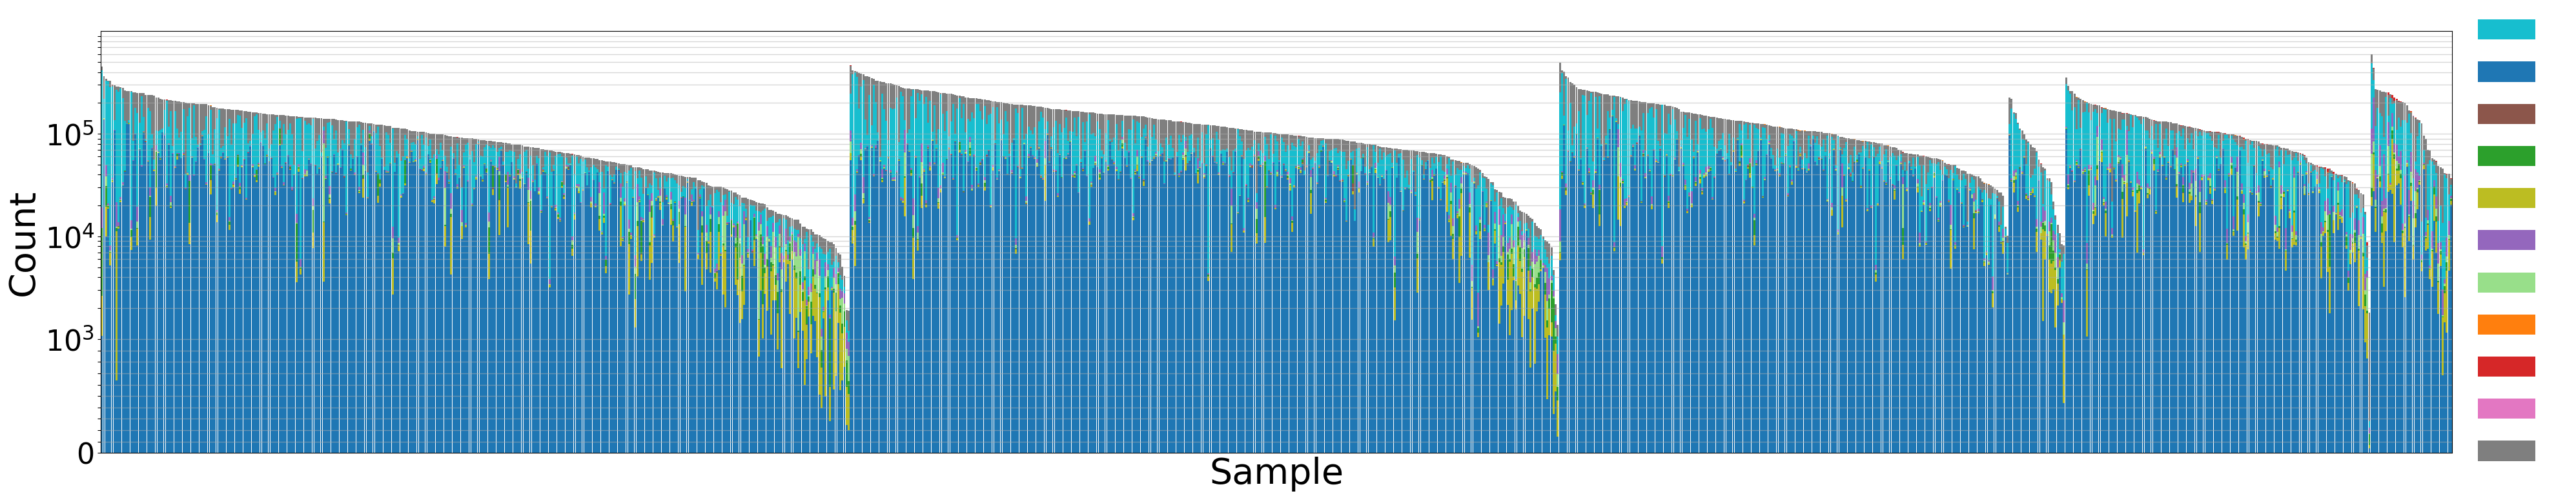

LSIL
HSIL
Adenocarcinoma


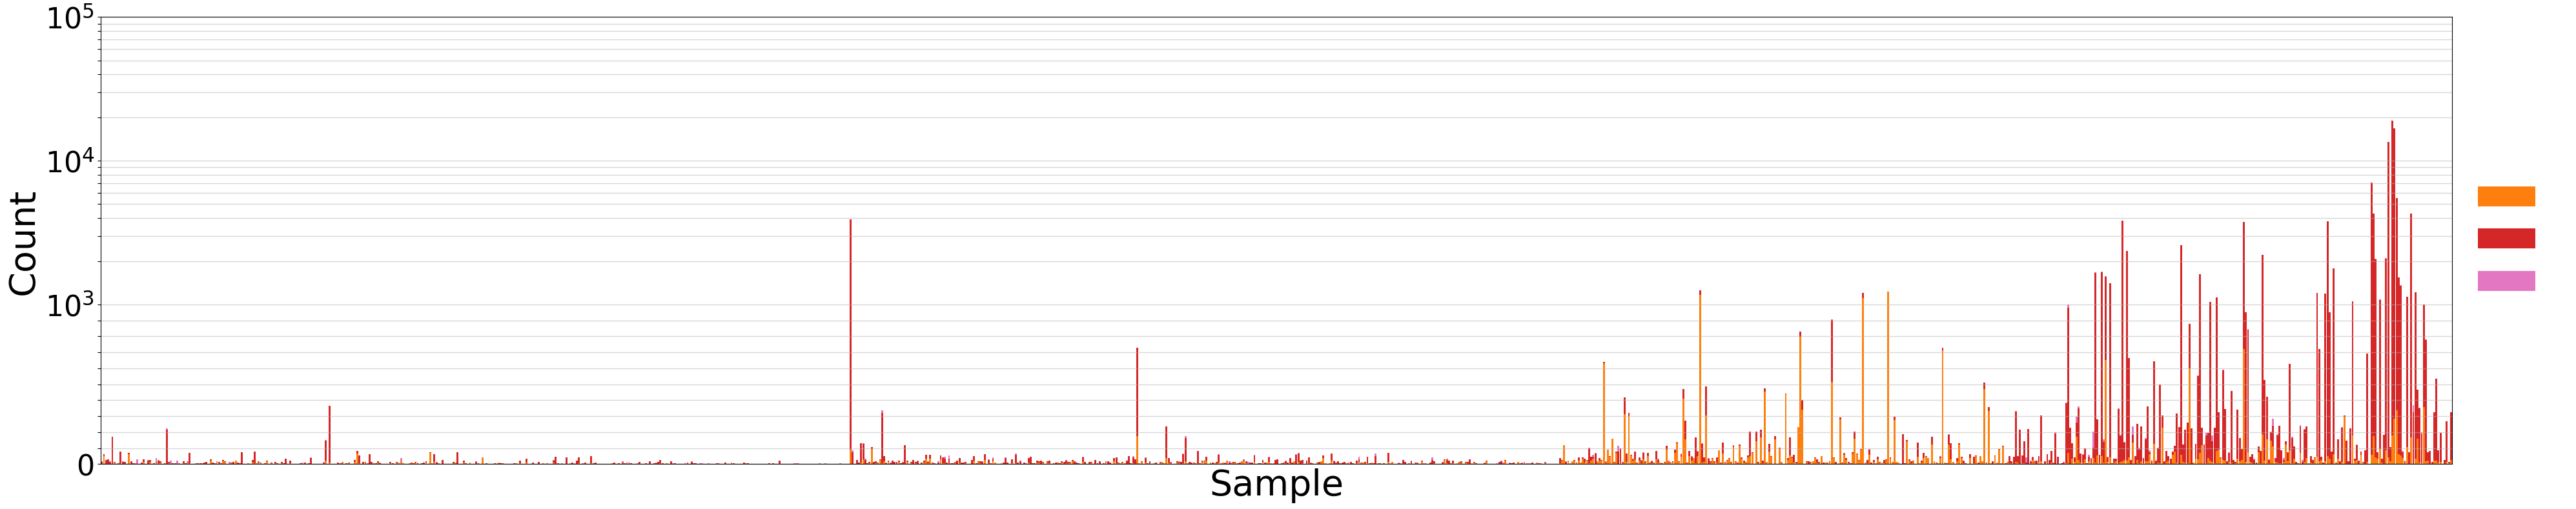

In [3]:
fig, ax = draw_hist_keycount(df_all, [], stack_order=custom_stack_order, legend_stack_order=legend_stack_order, legend_labels=legend_labels, yscale_type='biexp_1000_1_10', show_x_ticks=False, show_legend_text=False)
fig.savefig(f'{fig_dir}/Efig11c_all-slide-total-count.svg', bbox_inches='tight')


posilist = ['LSIL', 'HSIL', 'Adenocarcinoma']
fig, ax = draw_hist_keycount(df_all, posilist, stack_order=custom_stack_order, legend_stack_order=posilist, legend_labels=posilist, yscale_type='biexp_1000_1_10', show_x_ticks=False, show_legend_text=False)
fig.savefig(f'{fig_dir}/Efig11d_all-slide-positive-count.svg', bbox_inches='tight')

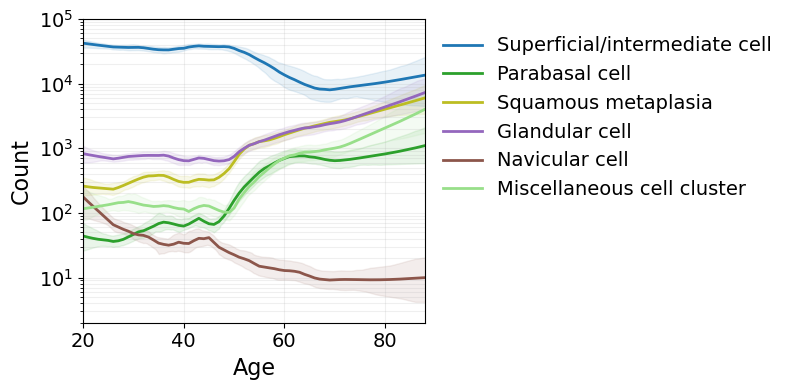

In [4]:

"""
# Age-related changes in the abundance of cytologically normal epithelial cell types in NILM samples.
LOWESS (Locally Weighted Scatterplot Smoothing) curves illustrate the age-associated trends in five types of cytologically normal epithelial cells 
from NILM (Negative for Intraepithelial Lesion or Malignancy) specimens: superficial/intermediate squamous cells, parabasal cells, squamous metaplastic 
cells, glandular cells, navicular cells, and miscellaneous cell clusters. The y-axis is shown on a logarithmic scale to accommodate differences in cell counts across types. 
Each line represents the smoothed estimate of cell count based on log-transformed data, and the shaded regions indicate 95% confidence intervals derived 
from bootstrap resampling (n = 100). This visualization reveals distinct age-related dynamics for each epithelial subpopulation, with substantial variation 
in both magnitude and trajectory across the lifespan.
"""

def draw_age_chart(df, savefilename='', xlim=(20,88), ylim=(20,200000), yscale_type='log'):
    nilm_cells = ['Squ.epi', 'Para.Squ', 'Squ.meta', 'Glan', 'Navicular', 'Para.Clust']
    nilm_legend_labels= ['Superficial/intermediate cell', 'Parabasal cell', 'Squamous metaplasia', 'Glandular cell', 'Navicular cell', 'Miscellaneous cell cluster']

    x_eval = np.linspace(20, 90, 200)

    plt.figure(figsize=(8, 4))

    for cell, label in zip(nilm_cells, nilm_legend_labels):
        x_data = df['Age'].values
        y_data = df[cell].values

        valid_idx = y_data > 0
        x_data = x_data[valid_idx]
        y_data = y_data[valid_idx]
        y_log = np.log(y_data)

        x_min = x_data.min()
        x_max = x_data.max()
        x_eval = np.linspace(x_min, x_max, 200)

        # LOWESS curve (median line)
        lowess = sm.nonparametric.lowess
        smoothed = lowess(y_log, x_data, frac=0.2, return_sorted=True)
        x_smooth = smoothed[:, 0]
        y_smooth = np.exp(smoothed[:, 1])

        # Bootstrap for confidence intervals
        n_bootstrap = 100
        y_boot = np.zeros((n_bootstrap, len(x_eval)))

        for i in range(n_bootstrap):
            idx = np.random.choice(len(x_data), size=len(x_data), replace=True)
            x_sample = x_data[idx]
            y_sample = y_log[idx]
            smoothed_sample = lowess(y_sample, x_sample, frac=0.2, return_sorted=True)
            y_interp = np.interp(x_eval, smoothed_sample[:, 0], np.exp(smoothed_sample[:, 1]))
            y_boot[i, :] = y_interp

        y_lower = np.percentile(y_boot, 2.5, axis=0)
        y_upper = np.percentile(y_boot, 97.5, axis=0)

        # Plot
        col = celltype_color_map.get(cell, 'black')
        plt.plot(x_smooth, y_smooth, color=col, label=label, linewidth=2)
        plt.fill_between(x_eval, y_lower, y_upper, color=col, alpha=0.1)

    # Axis settings
    plt.yscale('log')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.margins(x=0, y=0)
    plt.xlabel('Age', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.grid(True, which='both', linestyle='-', alpha=0.2)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=14)
    plt.tight_layout()
    if savefilename != '':
        plt.savefig(savefilename, bbox_inches='tight')
    plt.show()

draw_age_chart(df_all.query('Age>=20 and Age<90'), savefilename=f'{fig_dir}/Efig11a_age-celltype.svg', ylim=(2,100000))

In [5]:

def draw_violin_cytology(df, yparam, ylabel='', title='', savefilename='', yscale_type='linear'):

    df['Category'] = df['Class'] + ' / ' + df['Facility']
    category_order = [f'{cls} / {fac}' for cls in custom_class_order for fac in facilities.keys()]
    category_palette = {
        f'{cls} / {fac}': cytology_color_map.get(cls, 'gray') for cls in custom_class_order for fac in facilities.keys()
    }
    xticks = [i for i in range(len(custom_class_order)*len(facilities))]
    xlabels = list(facilities.values())*len(custom_class_order)
    plt.figure(figsize=(8, 4))

    # Violin plot
    sns.violinplot(
        x='Category',
        y=yparam,
        data=df,
        order=category_order,
        palette=category_palette,
        hue='Category',
        inner=None, 
        cut=0,      
        alpha=0.8, linewidth=0.5
    )

    # Overlay strip plot
    sns.stripplot(
        x='Category',
        y=yparam,
        data=df,
        order=category_order,
        color='black',
        size=1.5,
        jitter=0.3,
        alpha=0.5
    )

    # Plot settings
    ax = plt.gca()

    # Yaxis scale setting
    if yscale_type == 'log':
        ax.set_yscale(yscale_type)
    elif 'biexp' in yscale_type:
        _, breakpoint, linscale, base = yscale_type.split('_')  # Ex.) biexp_10_1.0_10
        breakpoint = int(breakpoint)
        linscale = float(linscale)
        base = int(base)
        ax.set_yscale('symlog', linthresh=breakpoint, linscale=linscale, base=base)
        ax.set_ylim(bottom=0)
        apply_biexp_yticks(ax, breakpoint=breakpoint, base=base)
    else:
        ax.set_yscale('linear')
        ax.set_ylim(bottom=0)

    # X axis label & ticks
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.tick_params(axis='x', which='major', pad=8, labelsize=14)
    ax.set_xlabel('')
    pair_centers = [4*i + 1.5 for i in range(len(custom_class_order))]
    secax = ax.secondary_xaxis('bottom')
    secax.set_ticks(pair_centers, labels=custom_class_order)
    secax.tick_params(axis='x', pad=35, labelsize=14, length=0) 
    trans = ax.get_xaxis_transform()
    y_line = -0.12
    for i in range(len(custom_class_order)):
        x1, x2 = 4*i, 4*i + 3
        ax.plot([x1-0.3, x2+0.3], [y_line, y_line], transform=trans, clip_on=False, lw=3, color=cytology_color_map[custom_class_order[i]])

    ax.text(-1.0, -0.08, 'Center:', transform=trans, ha='right', va='center', fontsize=14, clip_on=False)
    ax.text(-1.0, -0.18, 'Cytology:', transform=trans, ha='right', va='center', fontsize=14, clip_on=False)

    plt.tick_params(axis='y', labelsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel('')
    ax.grid(True, axis='y', which='major', linestyle='-', linewidth=1, alpha=0.3)
    if title != "":
        plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.grid(True, axis='y')
    if savefilename!='':
        plt.savefig(savefilename)
    plt.show()



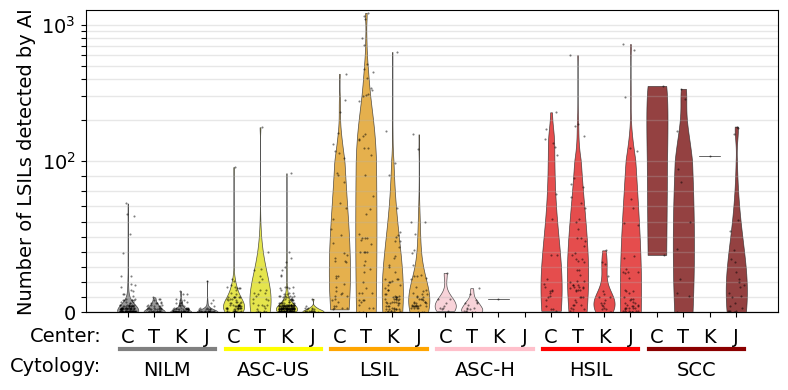

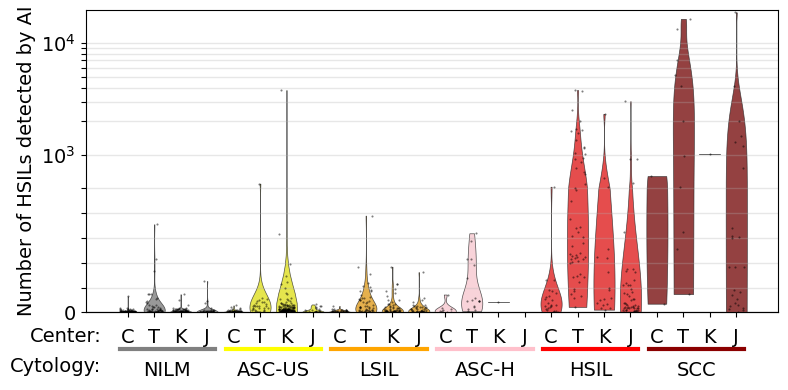

In [6]:
draw_violin_cytology(df_all, "LSIL", "Number of LSILs detected by AI", savefilename=f'{fig_dir}/fig7a_violin-lsil-facility.svg', yscale_type='biexp_100_1_10')
draw_violin_cytology(df_all, "HSIL", "Number of HSILs detected by AI", savefilename=f'{fig_dir}/fig7b_violin-hsil-facility.svg', yscale_type='biexp_500_1_10')